In [1]:
# Libraries
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics         import mean_squared_error
from sklearn.ensemble        import RandomForestRegressor
from sklearn.utils           import resample

warnings.filterwarnings('ignore')

In [2]:
# local file paths

dir_name = 'selezione'
region_names = np.array(['A', 'B', 'C'])

fp_Xtrain = []
fp_Xval   = []
fp_Xtest  = []
fp_ytrain = []
fp_yval   = []
fp_ytest  = []

for i in range(3):
    fp_Xtrain.append(dir_name + f'/X_train{region_names[i]}.csv')
    fp_Xval  .append(dir_name + f'/X_val{  region_names[i]}.csv')
    fp_Xtest .append(dir_name + f'/X_test{ region_names[i]}.csv')
    fp_ytrain.append(dir_name + f'/y_train{region_names[i]}.csv')
    fp_yval  .append(dir_name + f'/y_val{  region_names[i]}.csv')
    fp_ytest .append(dir_name + f'/y_test{ region_names[i]}.csv')

In [3]:
# Lettura dei dati

X_train = []
X_val   = []
X_test  = []
y_train = []
y_val   = []
y_test  = []

for i in range(3):
    X_train.append(pd.read_csv(fp_Xtrain[i], low_memory=False))
    X_val  .append(pd.read_csv(fp_Xval  [i], low_memory=False))        
    X_test .append(pd.read_csv(fp_Xtest [i], low_memory=False))
    y_train.append(pd.read_csv(fp_ytrain[i], low_memory=False))
    y_val  .append(pd.read_csv(fp_yval  [i], low_memory=False))        
    y_test .append(pd.read_csv(fp_ytest [i], low_memory=False))
    
X_train = np.array(X_train, dtype=object)
X_val   = np.array(X_val,   dtype=object)
X_test  = np.array(X_test,  dtype=object)
y_train = np.array(y_train, dtype=object)
y_val   = np.array(y_val,   dtype=object)
y_test  = np.array(y_test,  dtype=object)

In [4]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
            print()

In [5]:
dimensionality(y=True)

X_trainA: (26819, 41)
X_valA:   (9006, 41)
X_testA:  (9085, 41)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 34)
X_valB:   (2658, 34)
X_testB:  (2606, 34)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 48)
X_valC:   (21908, 48)
X_testC:  (21876, 48)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



Per limiti tecnici di memoria, la gestione del dataset C risulta complicata e incorre spesso in errori a run-time di cateoria __MemoryError__

Le macchine su cui sono eseguiti i notebook supportano operazioni su circa 30000 righe, quindi uso i 2/5 del dataset originale per la Regione C

In [6]:
perc = 2/5
ind  = 2
for X, y in zip([X_train, X_val, X_test], [y_train, y_val, y_test]):
    X[ind], y[ind] = resample(
        X[ind], y[ind],
        n_samples = int(perc * len(X[2]))
    )

In [7]:
dimensionality(y=True)

X_trainA: (26819, 41)
X_valA:   (9006, 41)
X_testA:  (9085, 41)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 34)
X_valB:   (2658, 34)
X_testB:  (2606, 34)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (25908, 48)
X_valC:   (8763, 48)
X_testC:  (8750, 48)
y_trainC: (25908, 1)
y_valC:   (8763, 1)
y_testC:  (8750, 1)



# Subset di testing

In [8]:
#sub_perc = [   1/3,     1,    1/3] # circa 8000
#sub_perc = [1/1000, 1/100, 1/1000] # circa 100, per testing
sub_perc = [     1,     1,      1] # dataset completo

In [9]:
for i in range(3):
    print(int(len(X_train[i])*sub_perc[i]))
    print(int(len(X_val  [i])*sub_perc[i]))
    print()

X_train_sub = []
y_train_sub = []
X_val_sub = []
y_val_sub = []

for i in range(3):
    Xt_sub, yt_sub = resample(X_train[i], y_train[i], n_samples = int(sub_perc[i]*len(X_train[i])))
    Xv_sub, yv_sub = resample(X_val  [i], y_val  [i], n_samples = int(sub_perc[i]*len(X_val[i])))
    X_train_sub.append(Xt_sub)
    y_train_sub.append(yt_sub)
    X_val_sub  .append(Xv_sub)
    y_val_sub  .append(yv_sub)

26
9

81
26

25
8



In [10]:
rf_model = []

# Costruzione RandomForestRegressor #

In [11]:
plt.rcParams.update({'font.size': 35})

In [12]:
def get_bias_var_mse(X, y, model):
        y_pred = model.predict(X)
        return {
            'bias': ((y - np.mean(y_pred))**2).mean(),\
            'var':  np.var(y_pred).mean(),\
            'mse':  ((y_pred - y.reshape(-1,1))**2).mean()
        }

In [13]:
# Costruzione RandomForestRegressor
def RandomForestRegressor_validation(X_train, y_train, X_val, y_val, verbose=False, debug=False, file_name = ''):
    
    def get_rf_reg(estimator):
        dt = RandomForestRegressor(
            n_estimators=estimator,
            # criterion = 'squared_error',
            n_jobs=-1
        )
        dt.fit(X_train, y_train)
        return dt
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'TUNING DEL MASSIMO NUMERO DI STIMATORI {name}')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = np.argmin(stats[n]) + START
            
            print (f'Punteggio finale: {stats[n][-1]} ({END}) stimatori')
            print (f'Best {n}: {min_}')
            print (f'Best number of Estimators: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(START, END+1),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(START, END+1),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(START, END+1),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f"{name} MSE, BIAS, VARIANCE on differe Estimators", fontsize=15)
        ax.set_xlabel("Number of Max Estimators used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
        if file_name != '':
            fig.savefig('images/' + file_name + '_' + name + '_random_forest.jpg')
        
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()

    START =   2
    END   =  100
    
    model_start = get_rf_reg(START)
    
    _, _, best_mse = bias_var_mse(X_train, y_train, model_start)
    
    best_estimator  = START
    best_model      = model_start
    
    info         = []
    
    train_stats  = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    val_stats    = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    } 
    
    for estimator in range(START, END+1):
        
        if debug:
            print(f'{estimator}/{END}')
    
        model = get_rf_reg(estimator)
        
        trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, model)
        val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, model)

        train_stats['bias'].append(trn_bias)
        train_stats['var' ].append(trn_var )
        train_stats['mse' ].append(trn_mse )
        
        val_stats['bias'].append(val_bias)
        val_stats['var' ].append(val_var )
        val_stats['mse' ].append(val_mse )
        
        info.append(f'Estimators: {estimator}' +\
                    f'\n(Train MSE:       {trn_mse }  - Val MSE:      {val_mse })' +\
                    f'\n(Train Bias:      {trn_bias}  - Val Bias:     {val_bias})' +\
                    f'\n(Train Variance:  {trn_var }  - Val Variance: {val_var })' )

        if(val_mse < best_mse):
            best_mse = val_mse
            best_estimator = estimator
            best_model = model
    
    if verbose:
        print()
        print("MSE, BIAS, VARIANCE Train e Validation")
        print(*info, sep='\n')
        print()
        
    plot_mse(train_stats, "TRAIN"     )
    plot_mse(  val_stats, "VALIDATION")
                
    return best_model

In [19]:
rf_model = []

In [20]:
def get_rf(index, verbose=False, debug=False, file_name=''):
    return RandomForestRegressor_validation(
        X_train_sub[index],\
        y_train_sub[index],\
        X_val_sub  [index],\
        y_val_sub  [index],\
        verbose   = verbose,\
        debug     = debug,\
        file_name = file_name
    )

TUNING DEL MASSIMO NUMERO DI STIMATORI TRAIN

Punteggio finale: 0.0025320847483240243 (100) stimatori
Best mse: 0.0022980843085344815
Best number of Estimators: 13

Punteggio finale: 0.0018966229026181618 (100) stimatori
Best bias: 0.001896593091133148
Best number of Estimators: 73

Punteggio finale: 0.0006354618457058626 (100) stimatori
Best var: 0.0004001870148489049
Best number of Estimators: 13

TUNING DEL MASSIMO NUMERO DI STIMATORI VALIDATION

Punteggio finale: 0.0033383511530309606 (100) stimatori
Best mse: 0.0030906542891097136
Best number of Estimators: 20

Punteggio finale: 0.003192223174959932 (100) stimatori
Best bias: 0.002962742546487338
Best number of Estimators: 5

Punteggio finale: 0.00014612797807102827 (100) stimatori
Best var: 7.537804360734898e-05
Best number of Estimators: 80

Wall time: 6.46 s


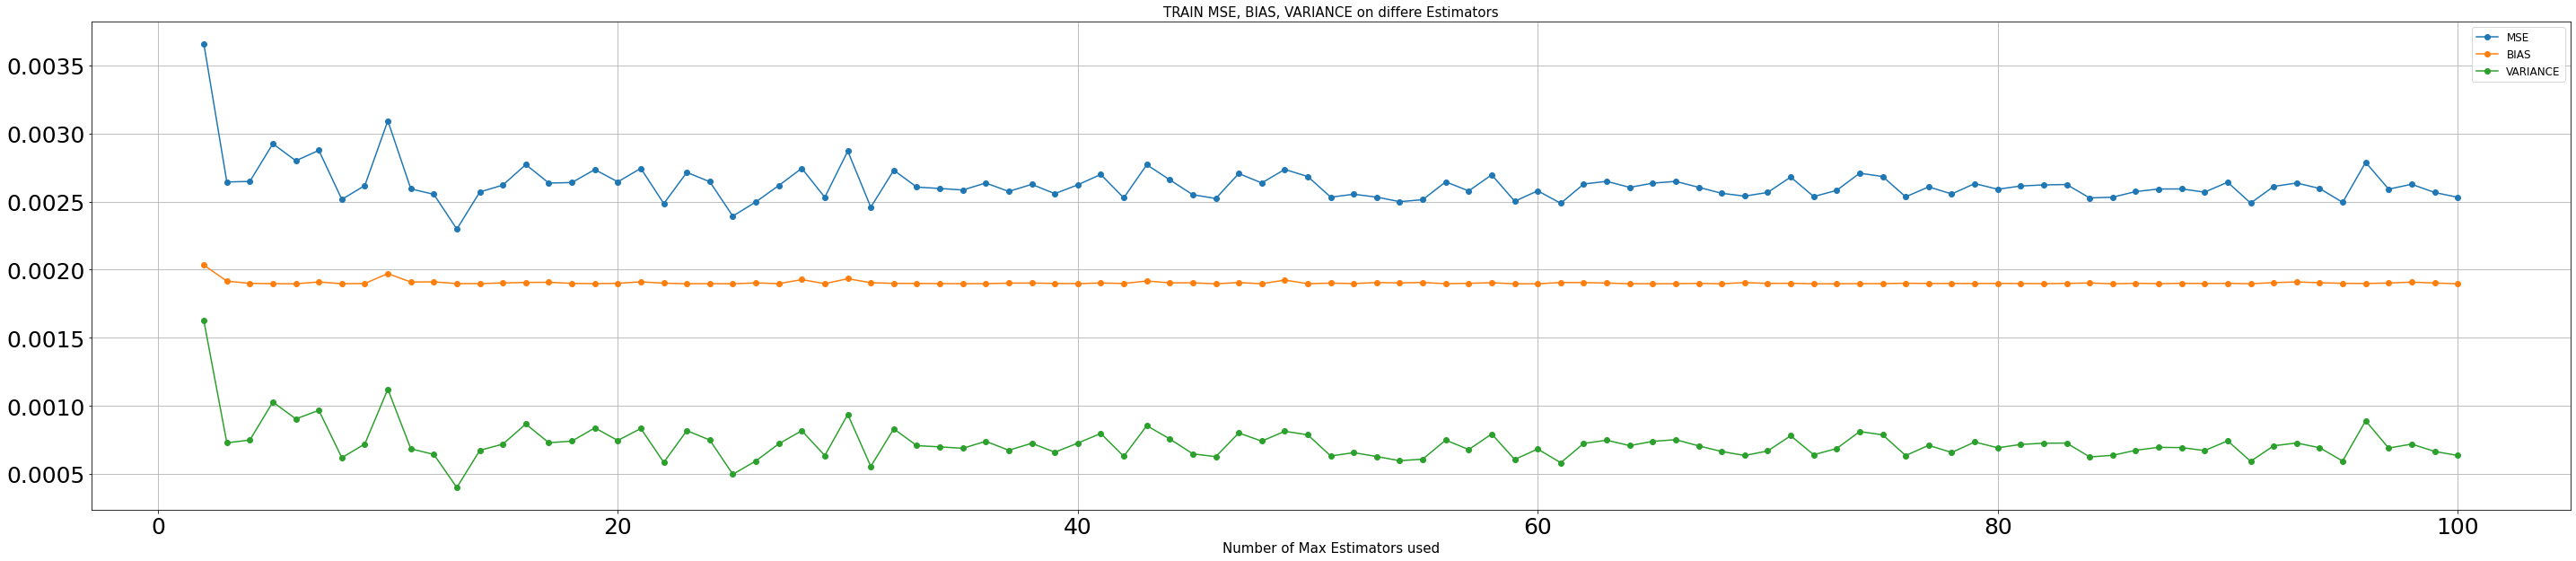

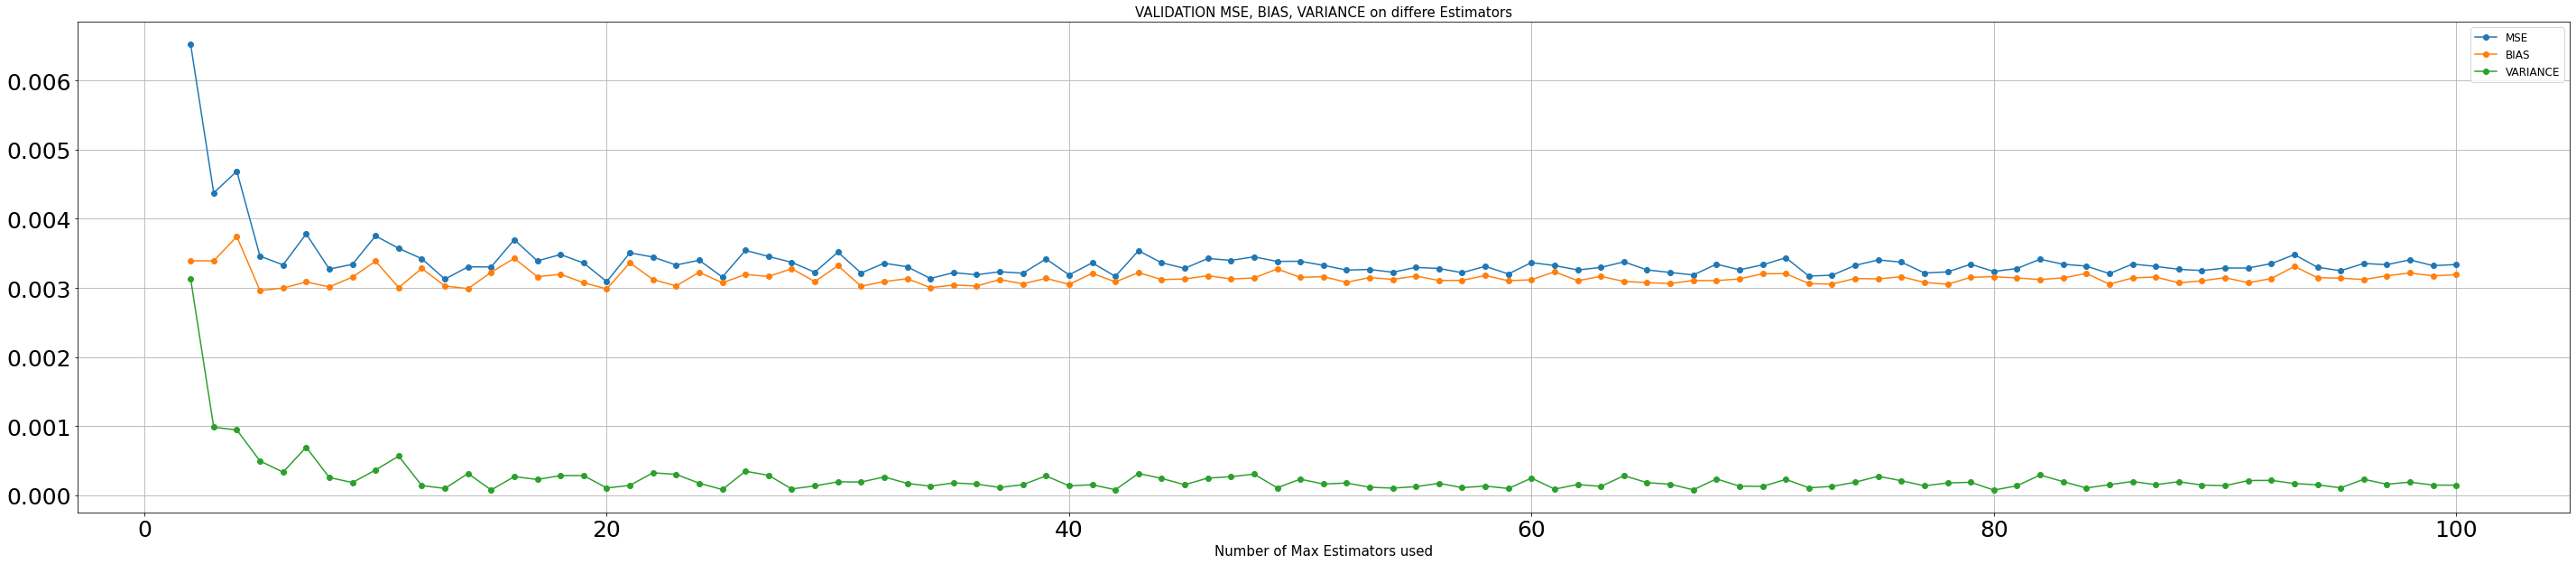

In [21]:
%%time
rf_model.append(
    get_rf(
        0,
        verbose = False,
        debug   = False,
        file_name = 'A'
    )
)

TUNING DEL MASSIMO NUMERO DI STIMATORI TRAIN

Punteggio finale: 0.013708193786532102 (100) stimatori
Best mse: 0.012481024150803698
Best number of Estimators: 17

Punteggio finale: 0.009132184228928074 (100) stimatori
Best bias: 0.009125306459152657
Best number of Estimators: 46

Punteggio finale: 0.004576009557604029 (100) stimatori
Best var: 0.003342021218213868
Best number of Estimators: 17

TUNING DEL MASSIMO NUMERO DI STIMATORI VALIDATION

Punteggio finale: 0.22626647698534186 (100) stimatori
Best mse: 0.22428059729616326
Best number of Estimators: 17

Punteggio finale: 0.2256011533647243 (100) stimatori
Best bias: 0.22289435753953343
Best number of Estimators: 15

Punteggio finale: 0.000665323620617498 (100) stimatori
Best var: 0.0005171602374662205
Best number of Estimators: 50



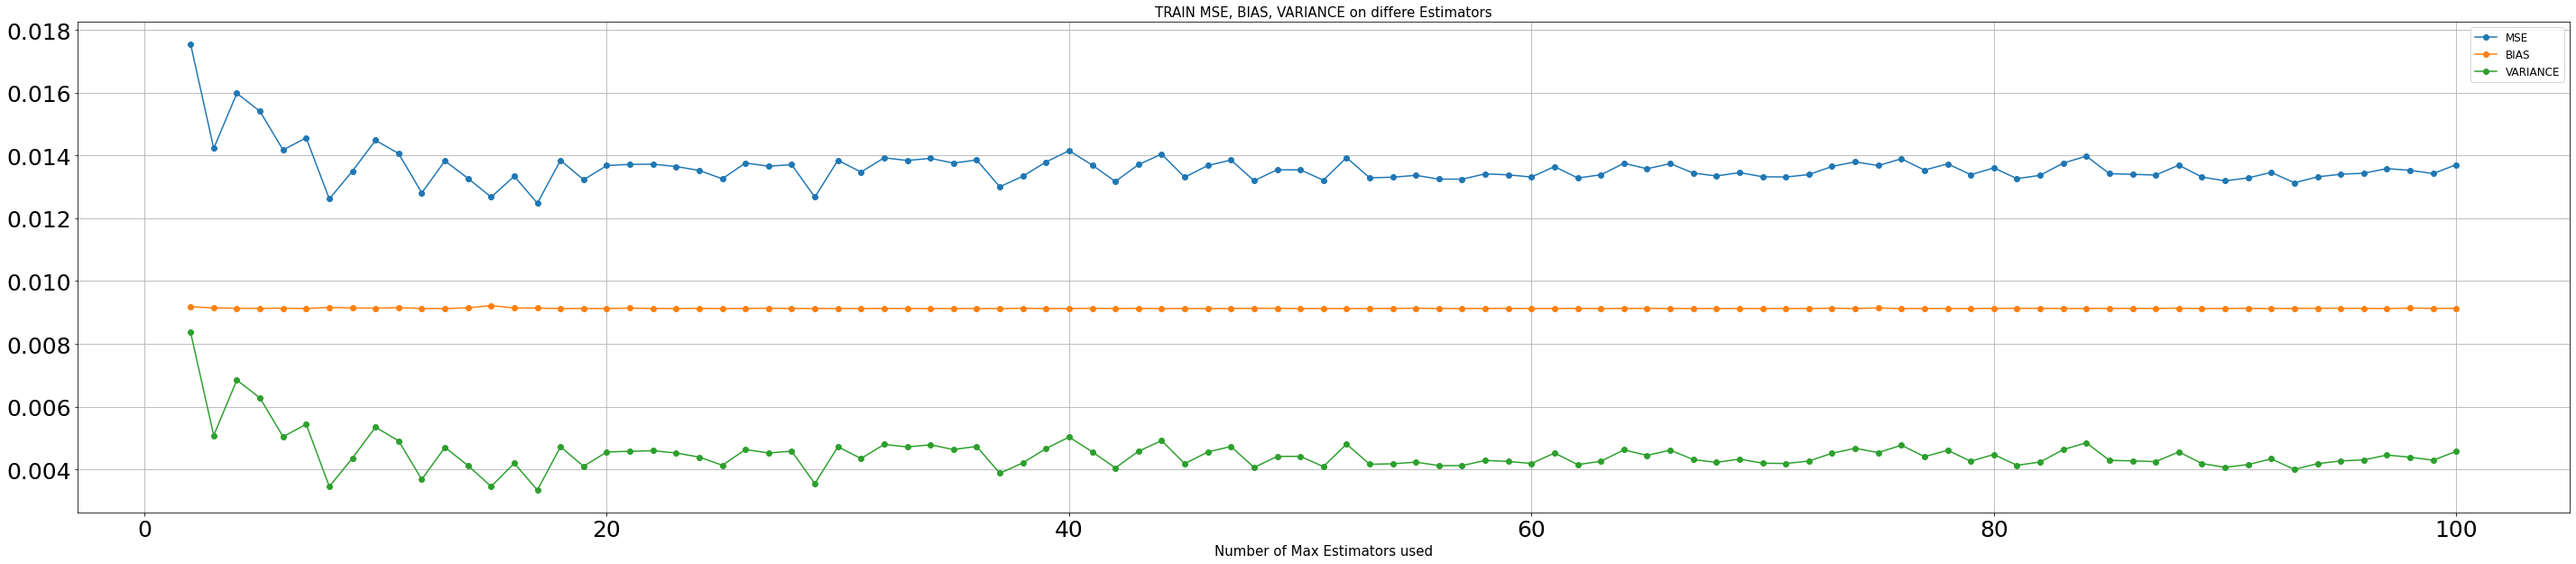

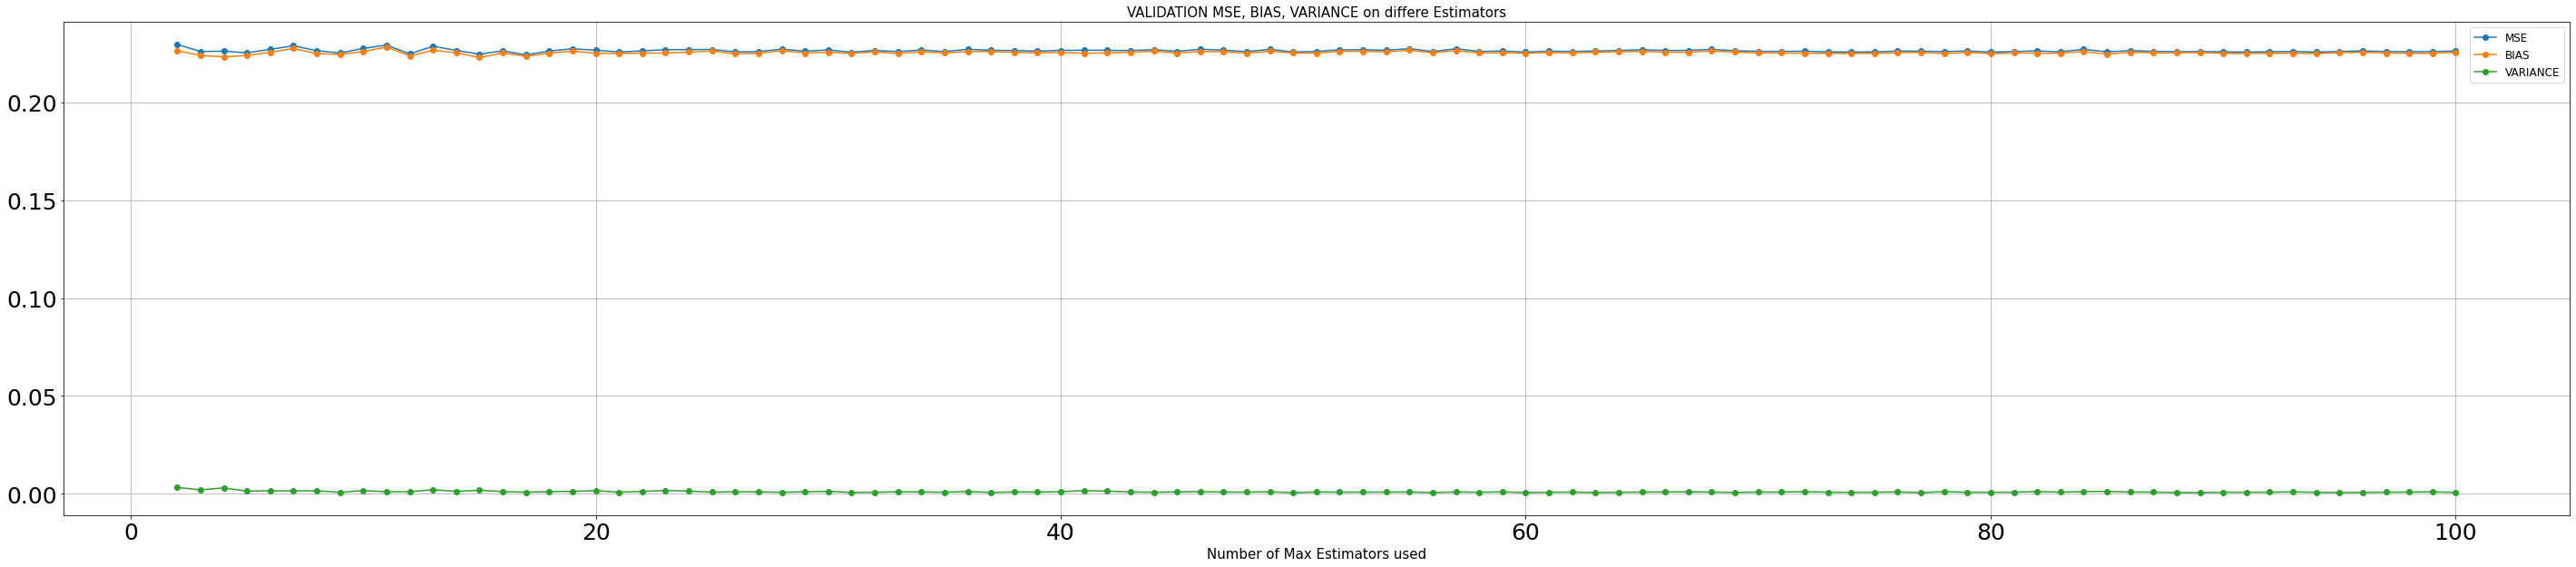

In [22]:
rf_model.append(
    get_rf(
        1,
        verbose = False,
        debug   = False,
        file_name = 'B'
    )
)

TUNING DEL MASSIMO NUMERO DI STIMATORI TRAIN

Punteggio finale: 0.002047602789741603 (100) stimatori
Best mse: 0.0019229565063708471
Best number of Estimators: 4

Punteggio finale: 0.0014215934903069574 (100) stimatori
Best bias: 0.001420113399638513
Best number of Estimators: 97

Punteggio finale: 0.0006260092994346462 (100) stimatori
Best var: 0.0004881862300928233
Best number of Estimators: 4

TUNING DEL MASSIMO NUMERO DI STIMATORI VALIDATION

Punteggio finale: 0.01886192980704464 (100) stimatori
Best mse: 0.01719148565915441
Best number of Estimators: 5

Punteggio finale: 0.01875496963497646 (100) stimatori
Best bias: 0.017082202982408104
Best number of Estimators: 5

Punteggio finale: 0.00010696017206818012 (100) stimatori
Best var: 7.107330971531049e-05
Best number of Estimators: 4



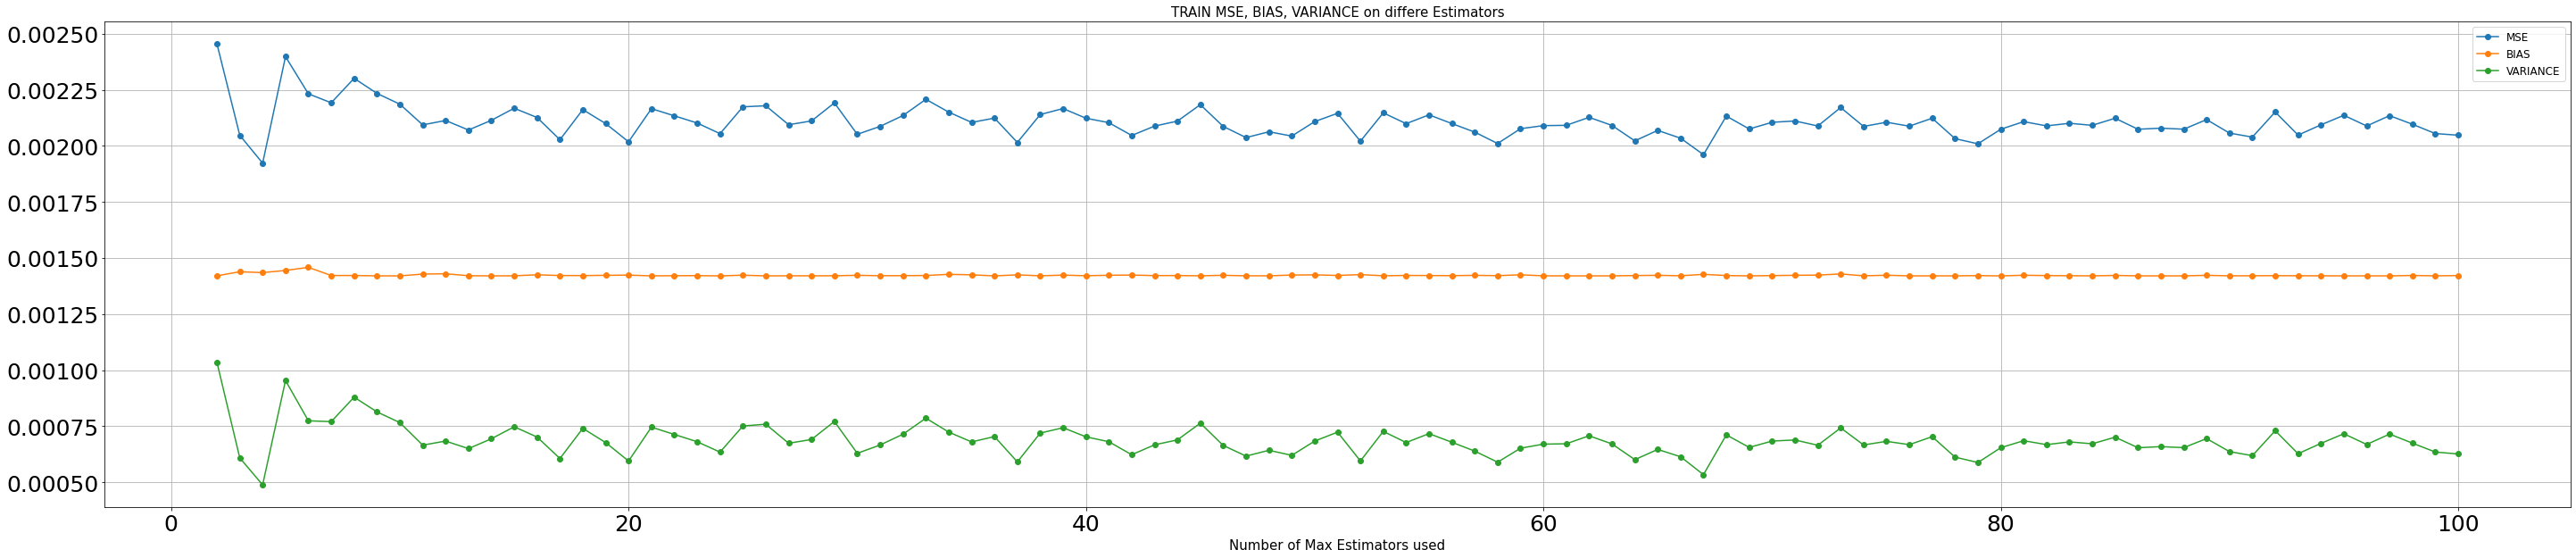

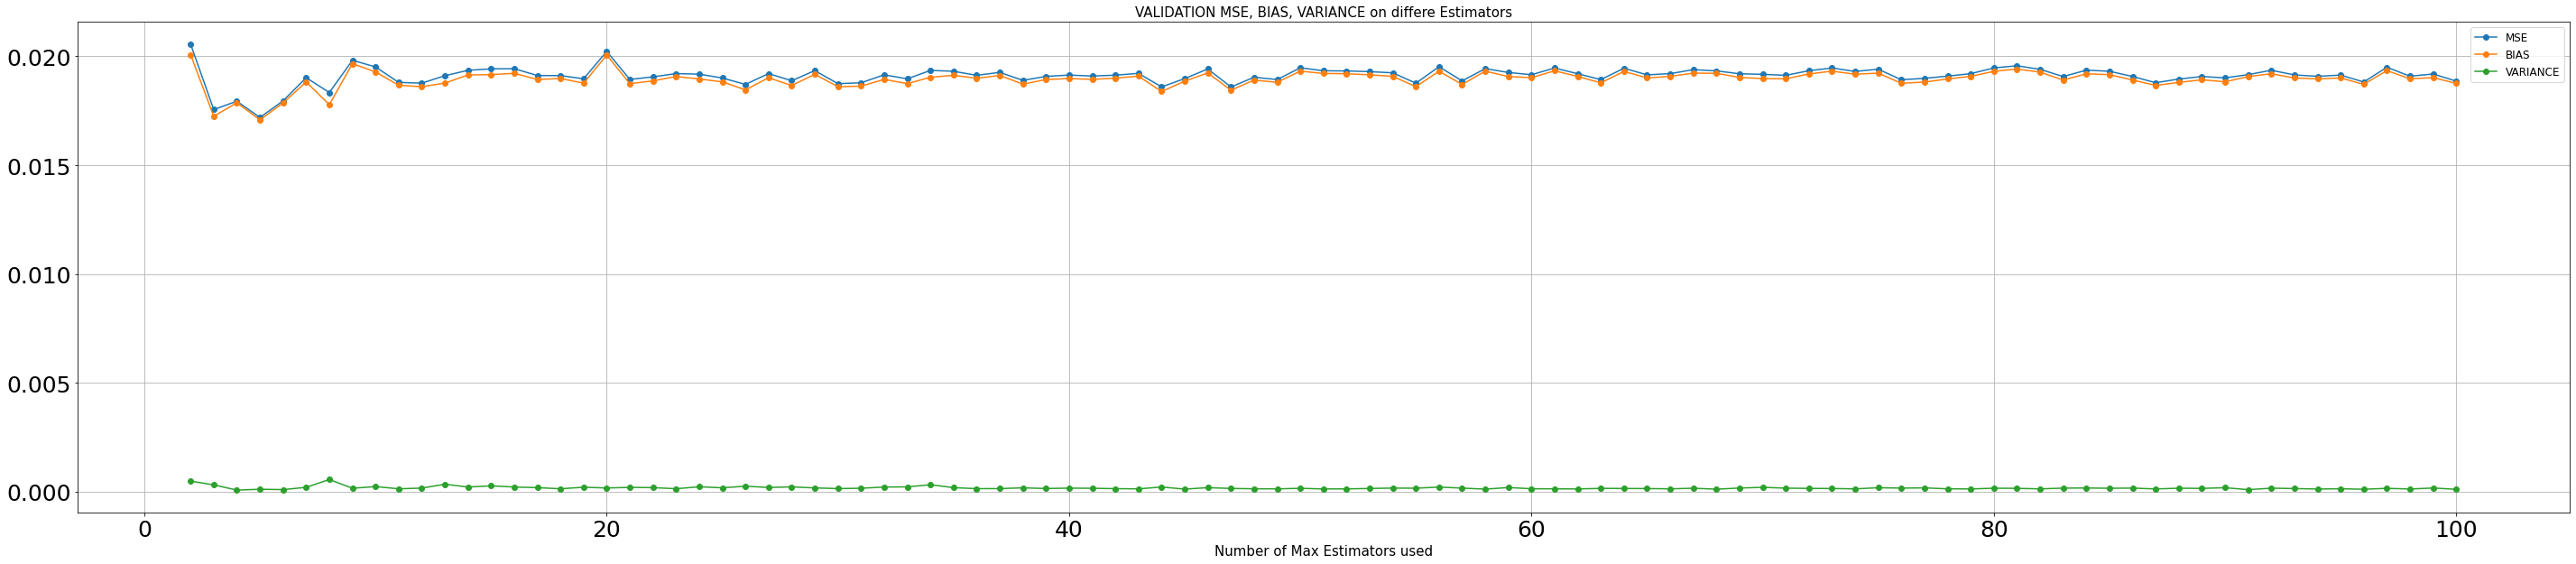

In [23]:
rf_model.append(
    get_rf(
        2,
        verbose = False,
        debug   = False,
        file_name = 'C'
    )
)

In [24]:
def get_score(model, X, y):
    return {
        'mse'  : mean_squared_error(y_true=y,   y_pred=model.predict(X)),
        'score': model.score(X, y)
    }

In [25]:
# Train
for i in range(3):
    print(region_names[i])
    print(get_score(rf_model[i], X_train[i], y_train[i]))
    print()

A
{'mse': 0.007753145309262107, 'score': -0.11888277595500774}

B
{'mse': 0.009902645409997484, 'score': -0.3143819328322188}

C
{'mse': 0.012234169732682411, 'score': -0.10566495466345316}



In [26]:
# Validation
for i in range(3):
    print(region_names[i])
    print(get_score(rf_model[i], X_val[i], y_val[i]))
    print()

A
{'mse': 0.028040649283484667, 'score': -0.028457718869690174}

B
{'mse': 0.022140551906689253, 'score': -0.12990023177667642}

C
{'mse': 0.02462411567541233, 'score': -0.060115027237607865}



In [27]:
# Test
for i in range(3):
    print(region_names[i])
    print(get_score(rf_model[i], X_test[i], y_test[i]))
    print()

A
{'mse': 0.02933795875408474, 'score': -0.025228422362436165}

B
{'mse': 0.026539974108954475, 'score': -0.10267961352275745}

C
{'mse': 0.02858303071852017, 'score': -0.0439372085477856}



Da dove proviene l'errore?

In [28]:
for i in range(3):
    print(region_names[i])
    print('Train     ', get_bias_var_mse(X_train[i], y_train[i].values.ravel(), rf_model[i]))
    print('Validation', get_bias_var_mse(X_val  [i], y_val  [i].values.ravel(), rf_model[i]))    
    print('Test      ', get_bias_var_mse(X_test [i], y_test [i].values.ravel(), rf_model[i]))  
    print()

A


KeyboardInterrupt: 

In [29]:
def feature_importance(X, rf, reg_name, file_name=''):
    
    print(f'{reg_name} FEATURE IMPORTANCES')
    print(list(X.columns[np.argsort(rf.feature_importances_)[::-1]]))
    print()
    
    fig, ax = plt.subplots(figsize=(len(rf.feature_importances_)/2,10))
    
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='x', which='minor', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=25)
    ax.tick_params(axis='y', which='minor', labelsize=30)
    
    ax.bar(range(0, X.shape[1]), rf.feature_importances_)
    ax.set_title(f'Feature Importances {reg_name}')
    ax.set_xticks(range(X.shape[1]))
    ax.set_xticklabels(X.columns, rotation=90)
    
    ax.grid()
    
    if file_name != '':
        fig.savefig('images/' + file_name + '_RandomForest_feature_importance.jpg')

A FEATURE IMPORTANCES
['structuretaxvaluedollarcnt', 'heatingorsystemtypeid_24.0', 'neighborhood_mean_price', 'tax_prop', 'finishedsquarefeet12', 'rawcensustractandblock', 'regionidzip', 'landtaxvaluedollarcnt', 'calculatedbathnbr', 'int_transactiondate', 'calculatedfinishedsquarefeet', 'poolcnt_1.0', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', 'living_area_prop', 'regionidcity', 'bedroomcnt', 'propertylandusetypeid_261.0', 'roomcnt', 'propertycountylandusecode_122', 'bathroomcnt', 'assessmentyear', 'period_mean_price', 'propertylandusetypeid_260.0', 'propertylandusetypeid_248.0', 'propertylandusetypeid_247.0', 'propertylandusetypeid_246.0', 'fireplacecnt', 'latitude', 'longitude', 'propertycountylandusecode_rare', 'propertycountylandusecode_34', 'heatingorsystemtypeid_18.0', 'heatingorsystemtypeid_7.0', 'heatingorsystemtypeid_6.0', 'unitcnt', 'unitcnt_na_flag', 'tax_ratio', 'propertylandusetypeid_266.0']

B FEATURE IMPORTANCES
['roomcnt', 'structuretaxvaluedoll

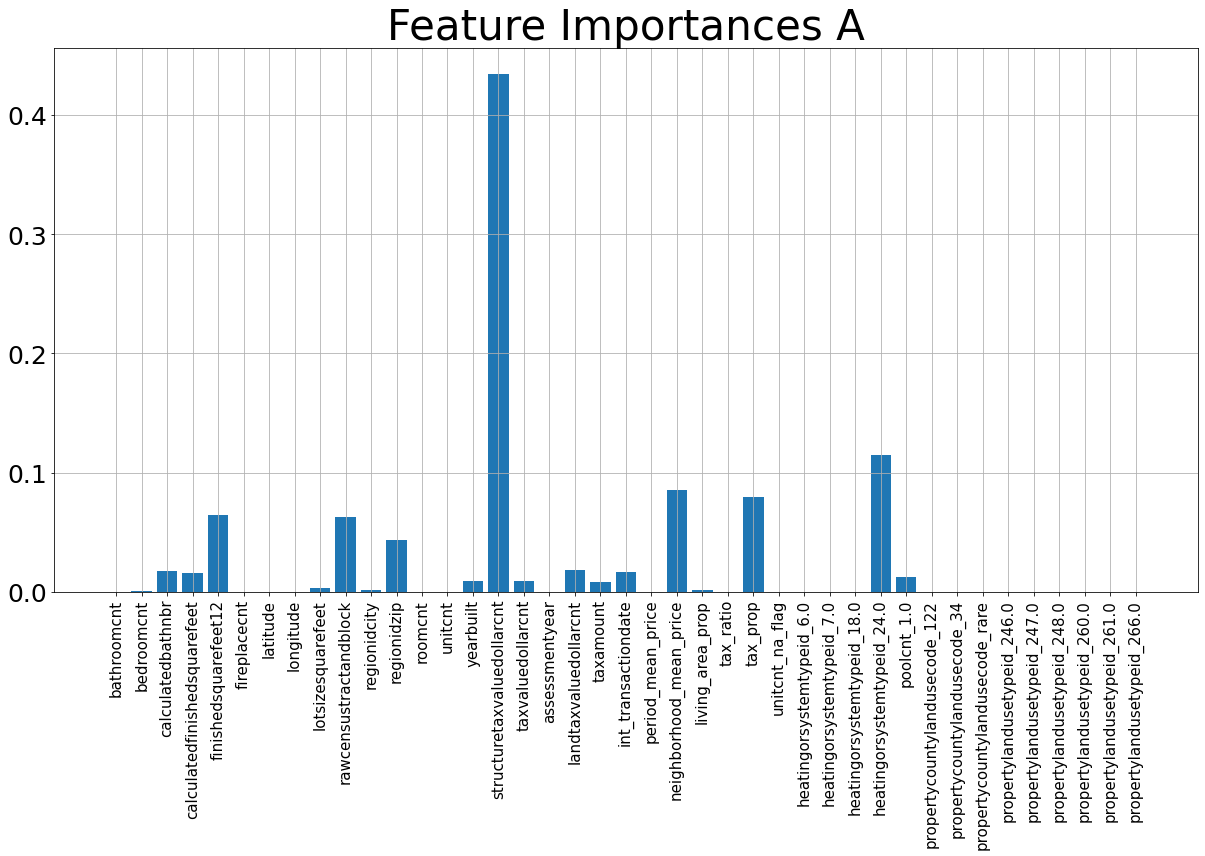

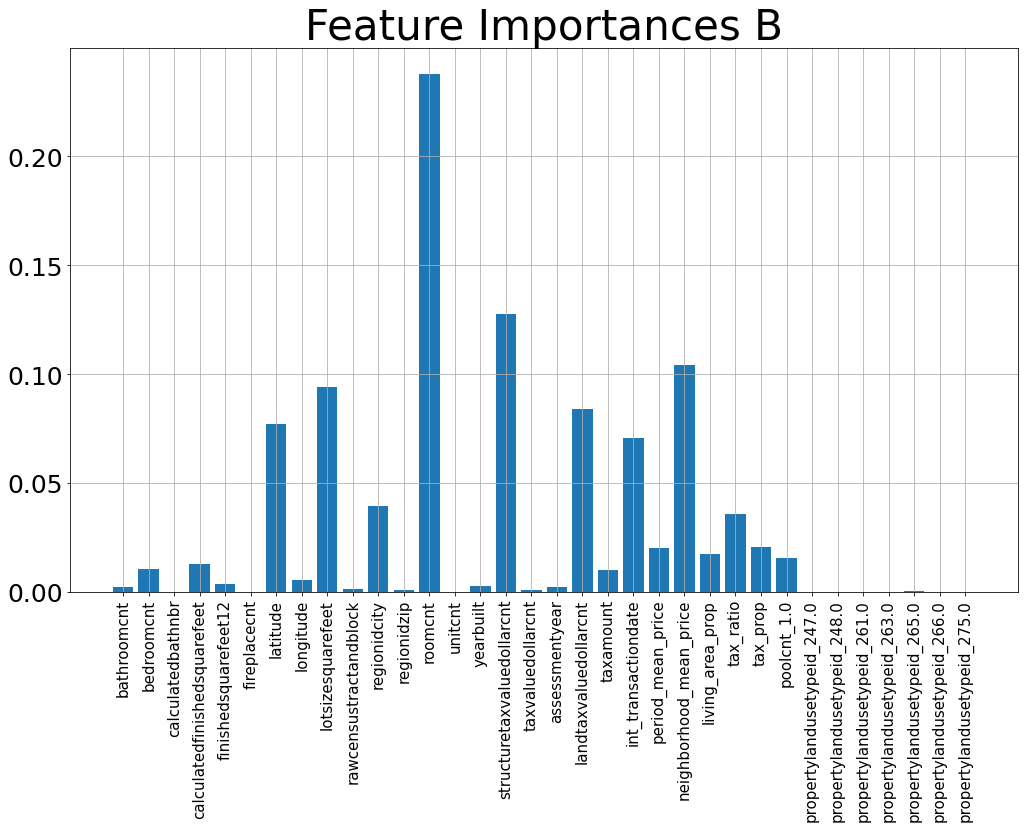

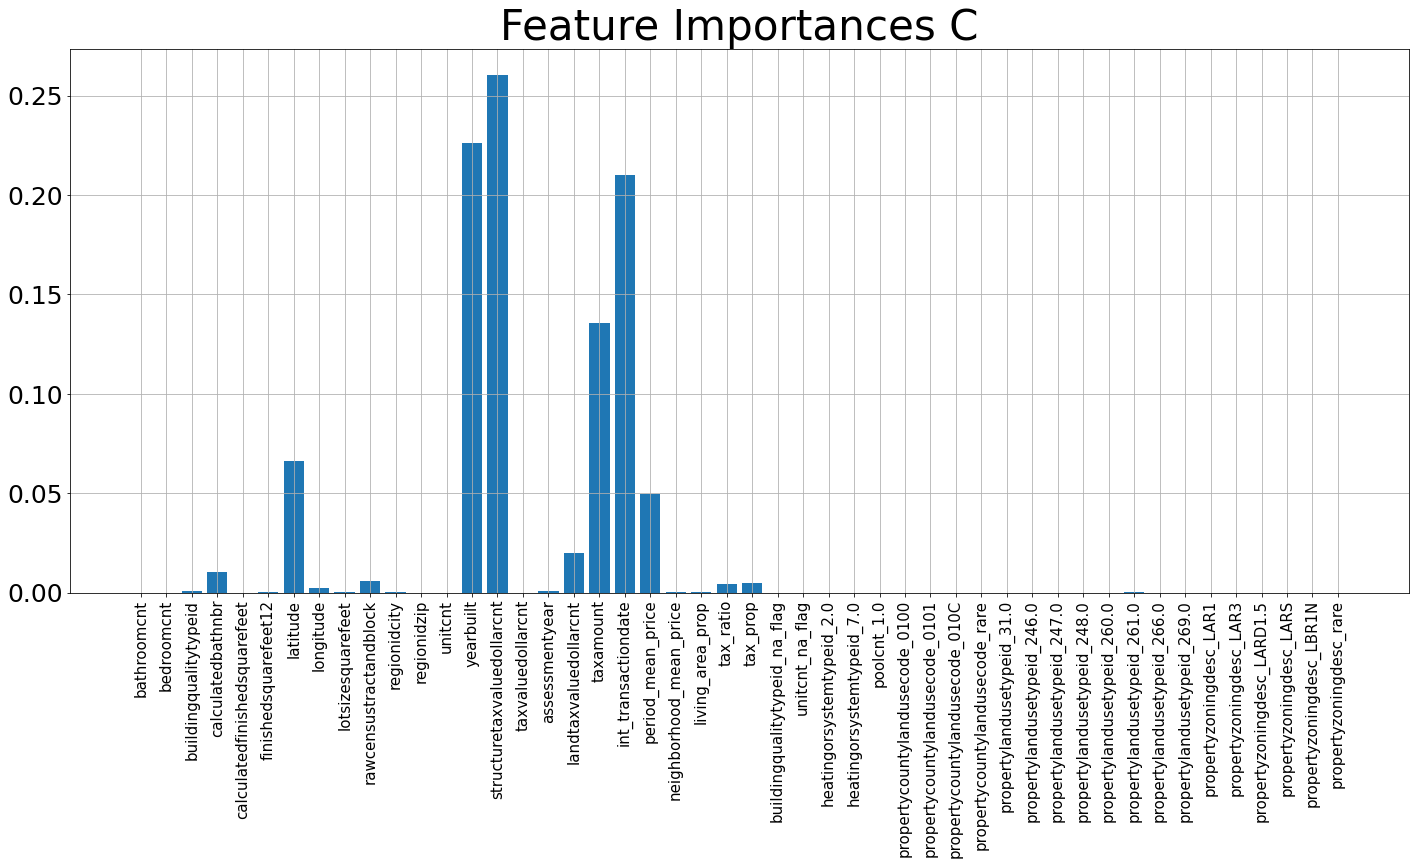

In [30]:
for i in range(3):
    feature_importance(
        X_train_sub[i],
        rf_model[i],
        region_names[i],
        file_name = region_names[i]
    )